In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.stats import binom, poisson, norm
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from numpy import trapz

In [2]:
plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [3]:
# Read in data
def read_data(filename):
    dat = np.genfromtxt(filename, delimiter='', names=('t', 'L', 'E','E2'))
    return dat


In [4]:
data1 = 'nu_e.dat'
data2 = 'nu_x.dat'
data3 = 'nubar_e.dat'
nu = read_data(data1)
nux = read_data(data2)
nubar = read_data(data3)
datt, datL, datE, datES = nu['t'], nu['L'], nu['E'], nu['E2']
dattx, datLx, datEx, datESx = nux['t'], nux['L'], nux['E'], nux['E2']
datt3, datL3, datE3, datES3 = nubar['t'], nubar['L'], nubar['E'], nubar['E2']

#Sort for t > 0 data
crit = datt>=0
critx = dattx>=0
crit3 = datt3>=0

t=datt[crit]*10**3
L=interp1d(t,datL[crit]*10**(-3),bounds_error=False, fill_value=0)
E=interp1d(t,datE[crit],bounds_error=False, fill_value=0)
ES=interp1d(t,datES[crit],bounds_error=False, fill_value=0)

tx=dattx[critx]*10**3
Lx=interp1d(tx,datLx[critx]*10**(-3),bounds_error=False, fill_value=0)
Ex=interp1d(tx,datEx[critx],bounds_error=False, fill_value=0)
ESx=interp1d(tx,datESx[critx],bounds_error=False, fill_value=0)

t3=datt3[crit3]*10**3
L3=interp1d(t3,datL3[crit3]*10**(-3),bounds_error=False, fill_value=0)
E3=interp1d(t3,datE3[crit3],bounds_error=False, fill_value=0)
ES3=interp1d(t3,datES3[crit3],bounds_error=False, fill_value=0)


#Calculate alpha Eq. (6)
a = ((2*E(t)**2-ES(t))/(ES(t)-E(t)**2))
a2 = (2*Ex(tx)**2-ESx(tx))/(ESx(tx)-Ex(tx)**2)
a3 = (2*E3(t3)**2-ES3(t3))/(ES3(t)-E3(t3)**2)


#a = interp1d(t,(2*E**2-ES)/(ES-E**2),bounds_error=False, fill_value=0)
#a2 = interp1d(t,(2*Ex**2-ESx)/(ESx-Ex**2),bounds_error=False, fill_value=0)
#a3 = interp1d(t,(2*E3**2-ES3)/(ES3-E3**2),bounds_error=False, fill_value=0)


In [5]:

xarr = np.linspace(0.1,100,4244)
def t_d(m):
    return 0.00515*(10/np.min(E(t)))**2*(m)**2 #E in MeV, m in eV

def newt(m): 
    return np.linspace(0,max(t+t_d(m)),4244)


#FLUX CALCULATION
from scipy.special import gamma, factorial
DS = 5.216493319*10**(10)
def F(x,L,E,ES):
    return (L/E)*1/E*(1+((2*E**2-ES)/(ES-E**2)))**(1+((2*E**2-ES)/(ES-E**2)))/gamma(1+((2*E**2-ES)/(ES-E**2)))*(x/E)**((2*E**2-ES)/(ES-E**2))*np.exp(-(1+((2*E**2-ES)/(ES-E**2)))*x/E)*5.216493319*10**(10)



def Fe(x,L,E,ES,te,m): #D in kpc, E in MeV, m in eV 
    td = 0.00515*(10/x)**2*(m)**2
    if td > te: 
        return 0
    else: 
        return F(x,L(te-td),E(te-td),ES(te-td))
    
def FLUXE(m,t):
    FLUX_NUE = np.zeros(4244)
    for i in range(0,len(t)):
        FLUX_NUE[i] = (integrate.quad(Fe, 0.1, 100, args=(L(t[i]),E(t[i]),ES(t[i]),t[i],m),limit=5,full_output=1,epsabs=1e-7,epsrel=1e-7)[0])
    return FLUX_NUE


FLUX_NUX = np.zeros(4244)
for i in range(0,len(tx)):
    FLUX_NUX[i] = (integrate.quad(F, 0.1, 100, args=(Lx(tx[i]),Ex(tx[i]),ESx(tx[i])),limit=5,full_output=1,epsabs=1e-7,epsrel=1e-7)[0])

FLUX3 = np.zeros(4244)
for i in range(0,len(t3)):
    FLUX3[i] = (integrate.quad(F, 0.1, 100, args=(L3(t3[i]),E3(t3[i]),ES3(t3[i])),limit=5,full_output=1,epsabs=1e-7,epsrel=1e-7)[0])

In [6]:
#FLUX CALCULATION
from scipy.special import gamma, factorial
DS = 5.216493319*10**(10)
def F(x,L,E,ES,te):
    return (L(te)/E(te))*1/E(te)*(1+((2*E(te)**2-ES(te))/(ES(te)-E(te)**2)))**(1+((2*E(te)**2-ES(te))/(ES(te)-E(te)**2)))/gamma(1+((2*E(te)**2-ES(te))/(ES(te)-E(te)**2)))*(x/E(te))**((2*E(te)**2-ES(te))/(ES(te)-E(te)**2))*np.exp(-(1+((2*E(te)**2-ES(te))/(ES(te)-E(te)**2)))*x/E(te))*5.216493319*10**(10)

def Fe(x,L,E,ES,te,m): #D in kpc, E in MeV, m in eV 
    td = 515*(1/x)**2*(m)**2
    if td > te: 
        return 0
    else: 
        #return F(x,L(te-td),E(te-td),ES(te-td))
        return (L(te-td)/E(te-td)**2)*(1+((2*E(te-td)**2-ES(te-td))/(ES(te-td)-E(te-td)**2)))**(1+((2*E(te-td)**2-ES(te-td))/(ES(te-td)-E(te-td)**2)))/gamma(1+((2*E(te-td)**2-ES(te-td))/(ES(te-td)-E(te-td)**2)))*(x/E(te-td))**((2*E(te-td)**2-ES(te-td))/(ES(te-td)-E(te-td)**2))*np.exp(-(1+((2*E(te-td)**2-ES(te-td))/(ES(te-td)-E(te-td)**2)))*x/E(te-td))*5.216493319*10**(10)

    
#def FLUXE(m,t):
 #   FLUX_NUE = np.zeros(4244)
  #  for i in range(0,len(t)):
   #     FLUX_NUE[i] = (integrate.quad(Fe, 0.1, 100, args=(L(t[i]),E(t[i]),ES(t[i]),t[i],m),limit=5,full_output=1,epsabs=1e-7,epsrel=1e-7)[0])
    #return FLUX_NUE


N = 300
N2 = 500
oldt = np.linspace(1,max(t),N)
def t_d(m):
    return 515*(1/4)**2*(m)**2 #E in MeV, m in eV

def newt(m): 
    return np.linspace(1,max(oldt)+t_d(m),N)

def P(m):
#plt.plot(oldt, np.asarray([integrate.quad(F, 1, 100, args=(L, E, ES,oldt[i]),limit=8,full_output=0,epsabs=1e-5,epsrel=1e-5)[0] for i in range(N)]))
    return np.asarray([integrate.quad(Fe, 1, 100, args=(L, E, ES, newt(5)[i],m),limit=5,full_output=0,epsabs=1e-4,epsrel=1e-4)[0] for i in range(len(newt(m)))])
#plt.plot(newt(4), np.asarray([integrate.quad(Fe, 1, 100, args=(L, E, ES, newt(4)[i],4),limit=5,full_output=0,epsabs=1e-4,epsrel=1e-4)[0] for i in range(N)]))

In [7]:
max(oldt)

567.932280255

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

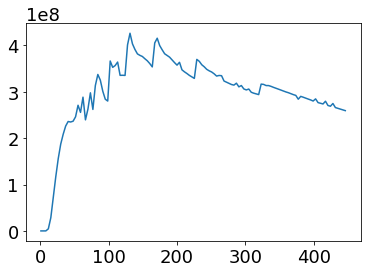

In [8]:
plt.plot(newt(4),P(4))

In [9]:
#plt.plot(newt(4),L(t-t_d(4)))

In [10]:
def fluxe(m):
    return np.asarray([integrate.quad(Fe, 1, 100, args=(L, E, ES, newt(m)[i],m),limit=3,full_output=0,epsabs=1e-6,epsrel=1e-6)[0] for i in range(N)])
def fluxeint(m):
    return interp1d(oldt,fluxe(m),bounds_error=False, fill_value=0)

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/Daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/Daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero 

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/Daniel/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (3) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

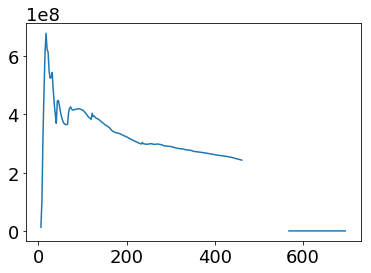

In [11]:
#plt.plot(newt(1),fluxe(1))
#plt.plot(newt(8),fluxe(8))
plt.plot(newt(2),fluxeint(2)(newt(2)))

In [12]:
#xarr = np.linspace(0.01,100,N)
#plt.plot(newt(10),Fe(xarr,L(newt(10)),E(newt(10)),ES(newt(10)),newt(10),10))
#plt.plot(oldt,F(14,L(oldt),E(oldt),ES(oldt),oldt))

print(f"{max(newt(4))}")
max(t)

1082.932280255


567.932280255

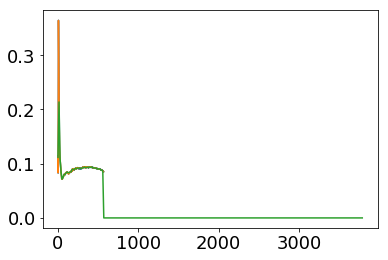

In [13]:
#Fe(xarr,L(t),E(t),ES(t),t,1)
plt.plot(t,L(t))
plt.plot(oldt,L(oldt))
plt.plot(newt(10),L(newt(10)))

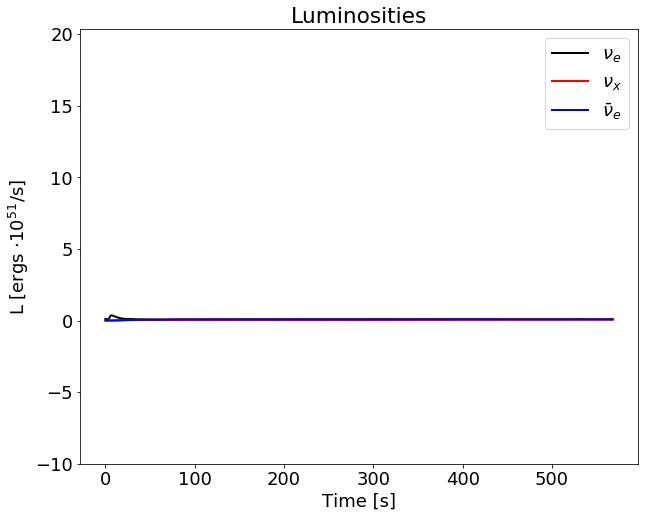

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set(ylim=(-10,max(L(t))+20), xlabel='Time [s]', ylabel='L [ergs $\cdot 10^{51}$/s]');
ax.set_title('Luminosities')

ax.plot(t, L(t), color='k', linestyle='-',linewidth=2)
ax.plot(tx, Lx(tx), color='r', linestyle='-',linewidth=2)
ax.plot(t3, L3(t3), color='b', linestyle='-',linewidth=2)
ax.legend((f'$\\nu_e$',f'$\\nu_x$','$\\bar{\\nu}_e$'))

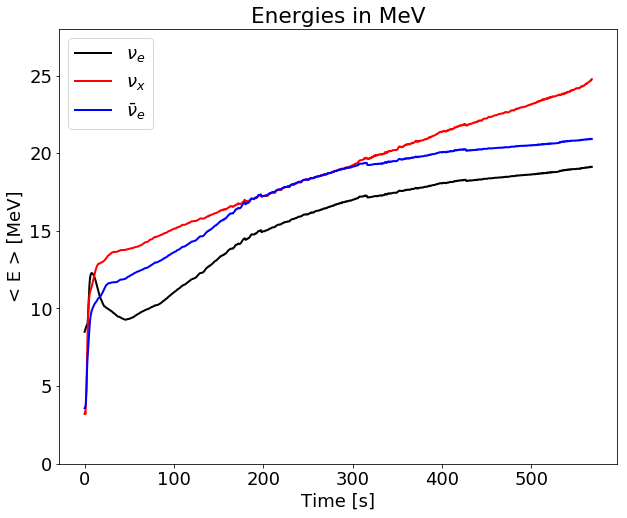

In [15]:
fig2, ax = plt.subplots(figsize=(10, 8))
ax.set(ylim=(0,28), xlabel='Time [s]', ylabel='< E > [MeV]');
ax.set_title('Energies in MeV')

ax.plot(t, E(t), color='k', linestyle='-',linewidth=2)
ax.plot(tx, Ex(tx), color='r', linestyle='-',linewidth=2)
ax.plot(t3, E3(t3), color='b', linestyle='-',linewidth=2)
ax.legend((f'$\\nu_e$',f'$\\nu_x$','$\\bar{\\nu}_e$'))

TypeError: F() missing 1 required positional argument: 'te'

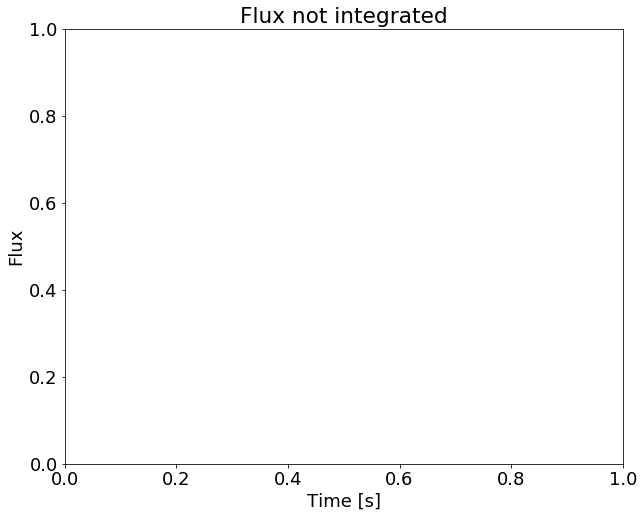

In [16]:
fig2, ax = plt.subplots(figsize=(10, 8))
ax.set(xlabel='Time [s]', ylabel='Flux');
ax.set_title('Flux not integrated')

#xarr = np.linspace(1,100,4244)
ax.plot(t, F(xarr,L(t),E(t),ES(t)), color='k', linestyle='-',linewidth=2)
ax.plot(tx, F(xarr,Lx(tx),Ex(tx),ESx(tx)), color='r', linestyle='-',linewidth=2)
ax.plot(t3, F(xarr,L3(t3),E3(t3),ES3(t3)), color='b', linestyle='-',linewidth=2)
ax.legend((f'$\\nu_e^0$',f'$\\nu_x^0$','$\\bar{\\nu}_e^0$'))

In [ ]:
#print(f'The flux integrated over time then gives number of neutrinos N_nue = {trapz(FLUX_NUE,t):.3} per cm^2')
#print(f'and N_nux = {trapz(FLUX_NUX,tx):.3} per cm^2')
fig2, ax = plt.subplots(figsize=(10, 8))
ax.set(xlabel='Time [s]', ylabel='Flux $[cm^2\cdot s]^{-1}$');
ax.set_title('Flux integrated over range 0-100 MeV')

ax.plot(t, FLUXE(1,t), color='k', linestyle='-',linewidth=2)
#ax.plot(tx, FLUX_NUX, color='r', linestyle='-',linewidth=2)
#ax.plot(t3, FLUX3, color='b', linestyle='-',linewidth=2)
ax.legend((f'$\\nu_e^0$',f'$\\nu_x^0$','$\\bar{\\nu}_e^0$'))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(newt(0),FLUXE(0,t),color='k', linestyle='-',linewidth=2)
#ax.plot(newt(3),FLUXE(3,t+t_d(3)+.001),color='r', linestyle='-',linewidth=2)
#ax.plot(newt(5),FLUXE(5,newt(5)+.001),color='g', linestyle='-',linewidth=2)
ax.plot(newt(8),FLUXE(8,newt(8)),color='b', linestyle='-',linewidth=2)
#ax.plot(t,FLUXE(10,t),color='y', linestyle='-',linewidth=2)

ax.set(xlabel='t [s]', ylabel='Flux $[cm^2\cdot s]^{-1}$');
ax.set_title('Individual Fluxes $F_{\\nu_e}^0$')
ax.legend((f'No Delay','$F_e^0, m_4 = 3 eV$',f'$F_e^0, m_4 = 5 eV$','$F_e^0, m_4 = 7$'))#,'$F_e^0, m_4 = 7$'))

In [ ]:
h = interp1d(t,FLUX_NUX,axis=0,bounds_error=False, fill_value=0)
newt2
def g(m):
    #return interp1d(newt(m),FLUXE(m,t),axis=0,bounds_error=False, fill_value=0)
    return interp1d(newt(m),FLUXE(m,t),axis=0,bounds_error=False, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t,g(0)(t),color='k', linestyle='--',linewidth=2)
#ax.plot(newt(1),g(1)(newt(1)+.001),color='m', linestyle='-',linewidth=2)
#ax.plot(newt(2),g(2)(newt(2)+.001),color='y', linestyle='-',linewidth=2)
ax.plot(newt(3),g(3)(newt(3)+0.0001),color='r', linestyle='-',linewidth=2)
#ax.plot(newt(5),g(5)(newt(5)+.0001),color='g', linestyle='-',linewidth=2)
#ax.plot(newt(8),g(8)(newt(8)+.0001),color='b', linestyle='-',linewidth=2)
#ax.plot(t,FLUXE(10,t),color='y', linestyle='-',linewidth=2)

ax.set(xlabel='t [s]', ylabel='Flux $[cm^2\cdot s]^{-1}$');
ax.set_title('Individual Fluxes $F_{\\nu_e}^0$ interpolated')
ax.legend((f'No delay',f'$\Delta t$ = {t_d(3):.3f} s, $m_4$ = 3 eV',f'$\Delta t$ = {t_d(2):.3f} s, $m_4$ = 2 eV',\
           f'$\Delta t$ = {t_d(3):.3f} s, $m_4$ = 3 eV',f'$\Delta t$ = {t_d(5):.3f} s, $m_4$ = 5 eV',\
           f'$\Delta t$ = {t_d(8):.3f} s, $m_4$ = 8 eV'))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(t,FLUXE(0,t-t_d(0)),color='k', linestyle='--',linewidth=1)
#ax.plot(newt(3),FLUXE(3,t-t_d(3)),color='r', linestyle='-',linewidth=2)
#ax.plot(newt(5),FLUXE(5,t-t_d(5)),color='g', linestyle='-',linewidth=1)
#ax.plot(newt(7),FLUXE(7,t-t_d(7)),color='b', linestyle='-',linewidth=2)

ax.plot(t, 0.02*g(0)(t+.0001)+0.98*h(t+0.0001), color='k', linestyle='--',linewidth=2)
ax.plot(newt(3), 0.02*g(3)(newt(3)+.0001)+0.96*h(newt(3)+0.0001), color='r', linestyle='-',linewidth=2)
ax.plot(newt(5), 0.02*g(5)(newt(5)+.0001)+0.96*h(newt(5)+0.0001), color='g', linestyle='-',linewidth=2)
ax.plot(newt(8), 0.02*g(8)(newt(8)+.0001)+0.96*h(newt(8)+0.0001), color='b', linestyle='-',linewidth=2)
#ax.plot(newt(11), 0.02*g(11)(newt(11)+.0001)+0.96*h(newt(11)+0.0001), color='y', linestyle='-',linewidth=2)


ax.set(xlabel='t [s]', ylabel='Flux $[cm^2\cdot s]^{-1}$');
ax.set_title('Total flux $F_{\\nu_e}^0$ + $F_{\\nu_x}^0$')
#ax.text(0.3,1.35*10**12,'N = $\int F(t)dt$',fontsize='18', color = 'k',style='italic')
#ax.text(0.3,1.2*10**12,'$N_e = 1.89\cdot10^{11} [cm^2]^{-1}$',fontsize='18', color = 'k',style='italic')
#ax.text(0.3,1.1*10**12,'$N_x = 7.78\cdot10^{10} [cm^2]^{-1}$',fontsize='18', color = 'k',style='italic')
ax.text(0.2,1.75*10**11,'$F_{\\nu_{e}} = c_{ee}F^0_{\\nu_e} + c_{xe}F^0_{\\nu_x}$',fontsize='18', color = 'k',style='italic')

ax.legend((f'3$\\nu$',f'$\Delta t$ = {t_d(3):.3f} s, $m_4$ = 3 eV',f'$\Delta t$ = {t_d(5):.3f} s, $m_4$ = 5 eV'\
           ,f'$\Delta t$ = {t_d(8):.3f} s, $m_4$ = 8 eV'))

In [ ]:
plt.plot(newt(8), 0.96*h(newt(8)+0.001))
plt.plot(newt(8), 0.02*g(8)(newt(8)+.001))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8)) #L [erg/s], F = L/<E>(4piD^2) [erg/(s*MeV*cm^2)]

ax.plot(newt(0), 0.02*FLUXE(0,t)+0.96*h(newt(0)+0.001), color='y', linestyle='--',linewidth=2)
ax.plot(newt(3), 0.02*FLUXE(3,t+t_d(3))+0.96*h(newt(3)+0.001), color='k', linestyle='-',linewidth=2)
ax.plot(newt(5), 0.02*FLUXE(5,t+t_d(5))+0.96*h(newt(5)+0.001), color='r', linestyle='-',linewidth=2)
#ax.plot(newt(7), 0.02*FLUXE(7,t+t_d(7))+0.96*h(newt(7)+0.001), color='g', linestyle='-',linewidth=2)
#ax.plot(newt(10), 0.02*FLUXE(10,t+t_d(10))+0.96*h(newt(10)+0.001), color='b', linestyle='-',linewidth=2)

ax.set(xlabel='t [s]', ylabel='$F_{\\nu_e}$ $[cm^2 \cdot s]^{-1}$')#,xlim=(0.5,0.9),ylim=(0,10**10));
ax.set_title('Total $\\nu_e$ flux')
ax.legend(('No delay','$m_4$ = 3 eV','$m_4$ = 5 eV','$m_4$ = 7 eV','$m_4$ = 10 eV'))

In [ ]:
max(t3)

In [ ]:
#print(f'The combined total flux integrated over time gives the number of electron neutrinos: N = {trapz(FLUXE,t):.3} per cm^2 at Earth')

In [ ]:
def DN(m):
    return interp1d(t+t_d(m),L(t)/E(t),axis=0,bounds_error=False, fill_value=0)


fig, ax = plt.subplots(figsize=(10, 8)) #L [erg/s], F = L/<E>(4piD^2) [erg/(s*MeV*cm^2)]
#Number of delayed neutrinos Ndel
ax.plot(newt(0),DN(0)(newt(0)+.000001), color='k', linestyle='-',linewidth=2) #Times 1*10 kpc
ax.plot(newt(3),DN(3)(newt(3)+.000001)*0.515*(3/xarr)**2, color='r', linestyle='-',linewidth=2) #Times 1*10 kpc
ax.plot(newt(5),DN(5)(newt(5)+.000001)*0.515*(5/xarr)**2, color='g', linestyle='-',linewidth=2) #Times 1*10 kpc
ax.plot(newt(7),DN(7)(newt(7)+.000001)*0.515*(7/xarr)**2, color='b', linestyle='-',linewidth=2) #Times 1*10 kpc
#ax.plot(newt(5),DN(5)(newt(5)+.000001)*0.515*(5/xarr)**2,color='k', linestyle='-',linewidth=2)
ax.set_title('Number of delayed neutrinos Ndel')

In [ ]:
#Number of delayed neutrinos Ndel
plt.plot(newt(5),0.02*DN(5)(newt(5)+.000001)*0.515*(5/xarr)**2+0.96*h(newt(3))) #Times 1*10 kpc

In [ ]:
plt.plot(newt(5),L(t-t_d(10))/E(t-t_d(10)))

In [ ]:
plt.plot(t,FLUXE(4,t))

In [ ]:
# Event rate detection
def Y(x,MW,L,E,ES,t):
    return 44*1.74*(MW/E)*L #*(x/E)**((2*E**2-ES)/(ES-E**2))*np.exp(-(1+((2*E**2-ES)/(ES-E**2)))*x/E)  #*0.0952*(x-1.3)**2*(1-7*x/16778.85)


def R(MW,m,t):
    I = np.zeros(4244)
    for i in range(0,len(t)):
        I[i] = (integrate.quad(Y, 0.1, 100, args=(MW,L(t)[t==max(t)][0],E(t[i]),ES(t[i]),t[i]),limit=5,full_output=1)[0])
        #I[i] = (integrate.quad(Y, 0.1, 100, args=(MW,L((t-t_d(m))[i]),E((t-t_d(m))[i]),ES((t-t_d(m))[i]),t[i]),limit=5,full_output=1)[0])
    return I


#def Y2(x,MW,L,E,a,t):
 #   return (1/E)*(x/E)**a*np.exp(-(1+a)*x/E)*100*x*L(t-)
#def R2(MW,t):
 #   I = np.zeros(4244)
  #  for i in range(0,len(t)):
   #     I[i] = (integrate.quad(Y, 0.1, 50, args=(MW,L(t[i]),E(t[i]),a[i],t[i]),limit=5,full_output=1)[0])
    #return I

In [ ]:
L(t)[t==max(t)][0]

In [ ]:
plt.plot(newt(8),L(t-t_d(8)))

In [ ]:
def newt2(m):
    return np.linspace(t_d(m),max(t)+t_d(m),4244)
plt.plot(newt2(5),44*1.74*(32/E(newt2(5)))*L(t)[t==max(t)][0])
plt.plot(newt2(8),44*1.74*(32/E(newt2(5)))*L(t)[t==max(t)][0])
plt.plot(newt(13),44*1.74*(32/E(t+t_d(13)))*L(t)[t==max(t)][0])
#plt.plot(t,R(200,5,t-t_d(8)))
#plt.plot(newt(5),R(760,5,t))
#plt.plot(newt(10),R(200,10,t-t_d(10)))
#plt.plot(t,R(200,5,t))

In [ ]:
plt.plot(t-t_d(1),1.74*(32/xarr)*L(t)[t==max(t)][0])
plt.plot(t-t_d(2),1.74*(32/xarr)*L(t)[t==max(t)][0])
plt.plot(t-t_d(3),1.74*(32/xarr)*L(t)[t==max(t)][0])

In [19]:
len(newt(8))

300

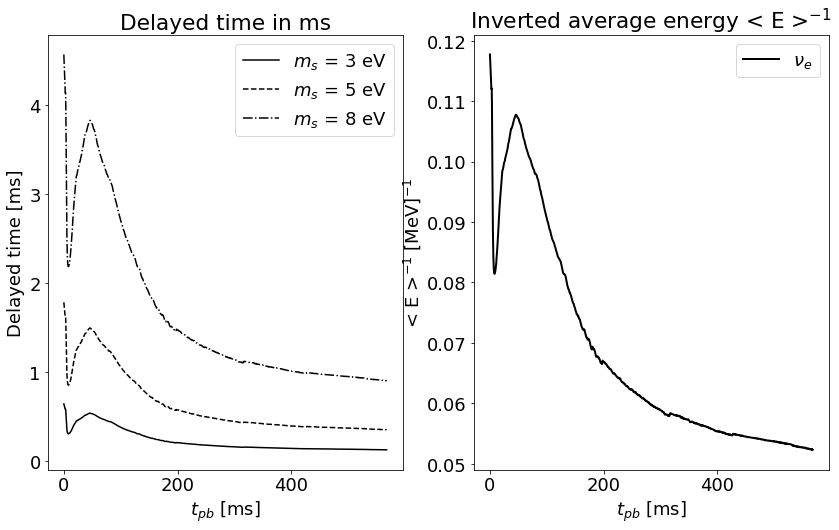

In [21]:
O = np.linspace(0,10,4244)
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(14, 8))
ax1.plot(t,5.15*(1/E(t))**2*3**2,'k-')
ax1.plot(t,5.15*(1/E(t))**2*5**2,'k--')
ax1.plot(t,5.15*(1/E(t))**2*8**2,'k-.')
#ax1.plot(np.linspace(0,max(t)+500,100),5.15*(8/E(t))**2*10**2,'k-.')
ax1.set(xlabel='$t_{pb}$ [ms]', ylabel='Delayed time [ms]');
ax1.set_title("Delayed time in ms")
ax1.legend(('$m_s$ = 3 eV','$m_s$ = 5 eV','$m_s$ = 8 eV'))

ax2.set(xlabel='$t_{pb}$ [ms]', ylabel='< E >${}^{-1}$ [MeV]${}^{-1}$');
ax2.set_title('Inverted average energy < E >${}^{-1}$')
ax2.plot(t, 1/E(t), color='k', linestyle='-',linewidth=2)
#ax2.plot(tx, Ex(tx), color='r', linestyle='-',linewidth=2)
#ax2.plot(t3, E3(t3), color='b', linestyle='-',linewidth=2)
ax2.legend((f'$\\nu_e$',f'$\\nu_x$','$\\bar{\\nu}_e$'))

In [ ]:
plt.plot(newt(8),5.15*(1/E(t))**2*8**2,'k-.')

In [ ]:
O = np.linspace(1,100,4244)
fig, (ax1, ax2) = plt.subplots(1,2,'none', figsize=(14, 8))
ax1.plot(O,515*(3/O)**2,'k-')
ax1.plot(O,515*(5/O)**2,'k--')
ax1.plot(O,515*(8/O)**2,'k-.')
ax1.axvline(x=min(E(t)),color='r',linestyle='--')
ax1.axvline(x=max(E(t)),color='r',linestyle='--')
ax1.set(xlim=(0,30),xlabel='$E_{\\nu}$ [MeV]', ylabel='Delayed time [ms]');
ax1.set_title("Delayed time in ms")
ax1.legend(('$m_s$ = 3 eV','$m_s$ = 5 eV','$m_s$ = 8 eV'))


ax2.plot(E(t),515*(3/E(t))**2,'k-')
ax2.plot(E(t),515*(5/E(t))**2,'k--')
ax2.plot(E(t),515*(8/E(t))**2,'k-.')
ax2.set(xlabel='< E > [MeV]', ylabel='Delayed time [ms]');
ax2.set_title("Delayed time in ms")
ax2.legend(('$m_s$ = 3 eV','$m_s$ = 5 eV','$m_s$ = 8 eV'))

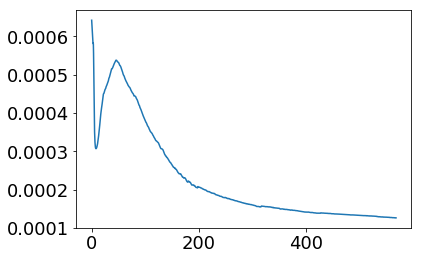

In [17]:
#plt.plot(t,0.00515*(10/E(t))**2*(10)**2)
#plt.plot(t,0.00515*(10/E(t))**2*(5)**2)
plt.plot(t,0.00515*(1/E(t))**2*(3)**2)

In [ ]:
plt.plot(t,0.00515*(10/E(t))**2*(3)**2)
#plt.plot(t,0.00515*(10/min(E(t)))**2*(3)**2)
0.00515*(10/np.mean(E(t)))**2*(3)**2

In [ ]:
max(E3(t3))

In [3]:
#Cross section
def cross(E,p,k):
    Epos = np.mean(E)-1.293 #Positron energy
    k = np.exp(-0.07056*log(np.mean(E))+0.02018*log(np.mean(E))**2-0.001953*log(np.mean(E))**4)*10**(-43)
    return k*ppos*Epos